# ESTE NOTEBOOK BUSCAR REALIZAR A APLICAÇÃO DOS MODELOS PARA UMA IMAGEM COMPLETA DO DRONE

- Para a realização disso, precisa-se entender a forma de calibração do modelo (entrada) e como isso pode ser otimizado para o formato da imagem e o posterior retorno dessa para a composição original

## IMPORTANDO BIBLIOTECAS

In [1]:
#warnings
import warnings
#time
import time
# data manipulation
import json
import numpy as np
import pandas as pd

# geospatial viz
import folium
from folium import Choropleth, Circle, Marker, Icon, Popup, FeatureGroup
from folium.plugins import HeatMap, FastMarkerCluster, MiniMap
from folium.features import GeoJsonPopup, GeoJsonTooltip

# plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches

#geospatial analysis
#import ee
import collections
import geopandas as gpd


#date manipulation
from datetime import timedelta
from datetime import datetime


#windows folder manipulation
import os

#statistics
import statistics
from statistics import mean
import scipy
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
from scipy.stats import zscore

#regressions, metrics and models optimizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split #split database in training and testing data
from sklearn.ensemble import RandomForestRegressor #randomforest regression
from sklearn.linear_model import LinearRegression, Lasso #linear regression or multiple linear regression
from sklearn.neural_network import MLPRegressor #neural network
from sklearn.svm import SVR #svm regression
from sklearn.model_selection import cross_validate, GridSearchCV, RepeatedKFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, make_scorer
from xgboost import XGBRegressor

#dataframe storage
import pickle

## MÉTODOS

In [2]:
warnings.simplefilter('ignore')

class Model():
    '''
        Model class encapsulate all methods to originate modelling results.
        
        Parameters:
        ------------
        X: pd.dataframe
            dataframe with independent (univariate) or independents (multivariate) variables
        y: pd.series
            dependent variable
        gv: bool
            set grid search to True or False
        model: Sklearn.model
            model desired | default = LinearRegression()
        wqp_unit: str
            enter wqp unit ex:mg/L
        mult_v: bool
            define if model is multivariate (more than one independent variable) or not. True or False
        m_type: str
            define the type of transformation to be applied in the data | default: linear (data as it is)
            Other types: 'poly', 'exp', 'log', 'standard_scaler', 'max_min'
        verbose: bool
            decide between printing processing results or not | default = True
        '''
    
    def __init__(self, X, y, gv=True, model=LinearRegression(), wqp_unit={}, mult_v = True, m_type = 'linear', verbose = True):
        self.X_name = ", ".join(list(X.columns))
        self.y_name = y.name
        self.gv = gv
        self.y = y
        self.model = model
        self.wqp_unit = wqp_unit
        self.result_dict = {}
        self.type = m_type
        self.mult_v = mult_v
        self.verbose = verbose
        if self.mult_v == False:
            self.X = np.array(X).reshape(-1,1)
            
        else:
            self.X = X

    def r2_func(self, y_obs, y_pred):
        ''' R2 metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        r2: float
            r2 metric
        '''
        
        if self.type == 'exp':
            y_obs, y_pred = np.exp(y_obs), np.exp(y_pred)
        else:
            pass
        y_hat = (1/len(y_obs))*sum(y_obs)
        TSS = sum((y_obs-y_hat)**2)
        RSS = sum((y_obs - y_pred)**2)
        r2 = round(1 - RSS/TSS,2)
        return r2

    def adj_r2_func(self, y_obs, y_pred):
        ''' Adjusted R2 metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        adj_r2: float
            adj_r2 metric
        '''
        if self.type == 'exp' and self.mult_v == False:
            adj_r2 = self.r2_func(y_obs, y_pred)
        else:
            n = y_obs.shape[0]
            p = self.X.shape[1]
            adj_r2 = round(1 - ((1 - self.r2_func(y_obs, y_pred)) * (n - 1))/(n-p-1), 2)
        return adj_r2
    
    def mae_func(self, y_obs, y_pred):
        ''' MAE metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        MAE: float
            MAE metric
        '''
        if self.type == 'exp':
            y_obs, y_pred = np.exp(y_obs), np.exp(y_pred)
        else:
            pass
        mae = round((np.sum(abs(y_obs - y_pred))/len(y_pred)), 2)
        return mae

    def mape_func(self, y_obs, y_pred):
        ''' MAPE metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        MAPE: float
            MAPE metric
        '''
        if self.type == 'exp':
            y_obs, y_pred = np.exp(y_obs), np.exp(y_pred)
        else:
            pass
        mape = round((np.sum(abs((y_obs - y_pred)/y_obs))/len(y_pred)), 2)
        return mape*100

    def rmse_func(self, y_obs, y_pred):
        ''' RMSE metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        RMSE: float
            RMSE metric
        '''
        if self.type == 'exp':
            y_obs, y_pred = np.exp(y_obs), np.exp(y_pred)
        else:
            pass
        rmse = round((sum((np.subtract(y_obs, y_pred))**2)/len(y_obs))**0.5,2)
        return rmse
    
    def nrmse_func(self, y_obs, y_pred):
        ''' NRMSE metric method
        Parameters
        ------------
        y_obs: array
            observed values (true values)
        y_pred: array
            estimated values (model output)
        Returns
        -----------
        NRMSE: float
            NRMSE metric
        '''
        if self.type == 'exp':
            y_obs, y_pred = np.exp(y_obs), np.exp(y_pred)
        else:
            pass
        rmse = (sum((np.subtract(y_obs, y_pred))**2)/len(y_obs))**0.5
        nrmse = round(rmse/mean(y_obs),2)
        return nrmse*100

    def scoring_func(self):
        ''' Scorer method uses sklearn make scorer method and allow
        to create the metric methods listed above.
        Parameters
        ------------
        self: instace
        Returns:
        ------------
        scoring: dict
            scoring dictionary with make_scorer as methods
        '''
        r2_score_t = make_scorer(self.r2_func, greater_is_better=True)
        adj_r2_score_t = make_scorer(self.adj_r2_func, greater_is_better=True)
        rmse_score = make_scorer(self.rmse_func, greater_is_better=False)
        nrmse_score = make_scorer(self.nrmse_func, greater_is_better=False)
        mae_score = make_scorer(self.mae_func, greater_is_better=False)
        mape_score = make_scorer(self.mape_func, greater_is_better=False)
        scoring = {'R²': r2_score_t, 
                   'Adjusted R²': adj_r2_score_t, 
                    'MAE': mae_score, 
                    'MAPE (%)': mape_score, 
                    'RMSE': rmse_score, 
                    'NRMSE (%)': nrmse_score}
        return scoring

    def boxplot_score(self, df, scores, palette):
        '''
        Boxplot plots method.
        Parameters
        -----------
        df: dataframe
            dataframe with metrics
        scores: list
            scores names
        palette: list
            colors to plot
        Returns
        ----------
        fig: image
            matplotlib plot
        '''
        cm = 1/2.54
        sns.set_context('paper')
        fig, axs = plt.subplots(ncols = 2, nrows=3, figsize=(30*cm, 30*cm))
        row, col = 0, 0
        for letter, score in zip(['a', 'b', 'c', 'd', 'e', 'f'], scores):
            e = sns.boxplot(ax = axs[row, col], data=df.melt(value_vars=["train_"+score, "test_"+score], value_name='score'), y='score', x='variable', palette=palette)
            e.set_xticklabels(['Train' + '\nn={:.0f}'.format(df["train_"+score].shape[0]) \
                               + '\nMedia: {:.2f}'.format(np.mean(df["train_"+score])) \
                               +'\nDesv. P.: {:.2f}'.format(np.std(df["train_"+score])),                                                     
                               'Test' + '\nn={:.0f}'.format(df["test_"+score].shape[0]) \
                               +'\nMedia: {:.2f}'.format(np.mean(df["test_"+score])) \
                               +'\nDesv. P.: {:.2f}'.format(np.std(df["test_"+score]))])
            if score.endswith("R²") or score.endswith("(%)"):
                e.set_ylabel(score)
            else:
                e.set_ylabel(score + ' ' + self.wqp_unit)
    
            e.set_xlabel('')
            e.spines['right'].set_visible(False)
            e.spines['left'].set_visible(True)
            e.spines['top'].set_visible(False)
            e.spines['bottom'].set_visible(True)
            e.yaxis.grid(color='gray', linestyle='dashed')
            e.yaxis.grid(color='gray', linestyle='dashed')
            e.set_title(letter)
            e.axhline(y = self.dummy_results.get(f"dummy_{score}"), c= 'red', linestyle='--')
            col +=1
    
            if col == 2:
                col = 0
                row+=1
                
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
        
        return plt.show()
    
    
    def validation_plots(self, residuals):
        '''
        Plots to be presented in validation step.
        Parameters
        -----------
        residuals: np.array
            array with residuals
        Returns
        ----------
        fig: image
            matplotlib plot
        '''
    
        def res_hist_plot(self, residuals):
            array = residuals
            #fig, ax = plt.subplots(figsize=(10*cm ,10*cm))
            g = sns.histplot(ax = axs[0,0], x=array)
            g.set_xlabel('Resíduos')
            g.set_ylabel('Frequência')
            g.set_title('a')
            #plt.show()
            return g
            
        def res_lineplot(self, residuals):
            
            g=sns.scatterplot(x = residuals.index, y = residuals, color='b', marker='.', ax = axs[0,1])
            g.axhline(y=0, c= 'red', linestyle='--')
            g.spines['right'].set_visible(False)
            g.spines['left'].set_visible(True)
            g.spines['top'].set_visible(False)
            g.spines['bottom'].set_visible(True)
            g.yaxis.grid(color='gray', linestyle='dashed')
            g.set_ylabel('∆ '+ g.get_ylabel())
            g.set_xlabel('Índice')
            g.set_title('b')
            g.set_xlim(g.get_xticks()[0]-0.5, g.get_xticks()[-1]+0.5)
            g.set_ylim(g.get_yticks()[0], g.get_yticks()[0] *-1)
            return g  
            
        def res_qq_plot(self, residuals):
            array = residuals
            array_norm = (array - array.mean()) / array.std()
            array_norm=array_norm.sort_values(ascending=True)
            norm_dist = np.random.normal(loc=0, scale=1, size=len(array_norm))
            norm_dist.sort()
            ax = sns.scatterplot(x = norm_dist, y = array_norm, marker='.', color='b', ax = axs[1,0])
            ax.plot(norm_dist, norm_dist, c='red')
            lims = [norm_dist.min(), norm_dist.max()]
            ax.set_xlim(lims)
            ax.set_ylim(lims)
            ax.set_xlabel("Quantis da Distribuição Normal")
            ax.set_ylabel("Quantis Observados")
            ax.set_aspect('equal')
            ax.set_title('c')
            return ax
            
        def pred_obs_scatter(self):
            h = sns.scatterplot(x = self.y_test, y=self.y_pred, color='darkgrey', ax = axs[1,1])      
            h.spines['right'].set_visible(True)
            h.spines['left'].set_visible(True)
            h.spines['top'].set_visible(True)
            h.spines['bottom'].set_visible(True)
            h.set_ylabel('Valores estimados de '+ h.get_xlabel())
            h.set_xlabel('Valores observados de '+ h.get_xlabel())
            h.set_title('Correlação entre valores estimados e observados')
            lims = [
                np.min([h.get_xlim(), h.get_ylim()]),  # min of both axes
                np.max([h.get_xlim(), h.get_ylim()]),  # max of both axes
            ]
            if lims[0]<0:
                lims[0]=0
            else:
                pass
            # now plot both limits against eachother
            h.plot(lims, lims, '--', alpha=0.5, zorder=0, color='gray')
            h.text(0.93, 0.9,'1:1', fontdict={'family': 'arial', 'color':  'black', 'weight': 'light', 'size': 10, 'rotation': '45'}, transform=h.transAxes)
            h.set_title('d')
            h.set_xticks(h.get_yticks())
            h.set_xlim(lims)
            h.set_ylim(lims)
            h.set_aspect('equal')
            h.text(0.02,
                   0.98,
                   "n = {} | R²: {:.2f} | AdjR²: {:.2f}".format(self.y_test.shape[0], self.val_r2, self.val_adj_r2),
                   fontdict={'ha': 'left', 'va': 'top', 'family': 'arial', 'color':  'black', 'weight': 'light', 'size': 10, 'rotation': '0'},
                   transform=h.transAxes)
            
            h.text(0.99,
                   0.01,
                   "MAE: " + "{:.1f} {} |".format(self.val_mae, self.wqp_unit) \
                   + " MAPE: " + "{:.0f} %".format(self.val_mape) \
                   + "\nRMSE: " + "{:.1f} {} |".format(self.val_rmse, self.wqp_unit) \
                   + " nRMSE: " + "{:.0f} %".format(self.val_nrmse),
                   fontdict={'ha': 'right', 'va': 'bottom', 'family': 'arial', 'color':  'black', 'weight': 'light', 'size': 10, 'rotation': '0'},
                   transform=h.transAxes)
            return h
        
        cm = 1/2.54
        fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(30*cm, 30*cm))
        res_hist_plot(self, residuals)
        res_lineplot(self, residuals)
        res_qq_plot(self, residuals)
        pred_obs_scatter(self)
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.2)
        return plt.show()
            
    def train_test_split_data(self, rs = None):
        self.test_rs = rs
        if self.type == 'linear':
            self.X, self.y = self.X, self.y
        elif self.type == 'poly':
            poly = PolynomialFeatures(degree = 2)
            self.X, self.y = poly.fit_transform(self.X), self.y
        elif self.type == 'exp':
            self.X, self.y = self.X, np.log(self.y)
        elif self.type == 'log':
            self.X, self.y = np.log(self.X), self.y
        elif self.type == 'standard_scaler':
            scaler = StandardScaler()
            self.X, self.y = scaler.fit_transform(self.X), self.y
        elif self.type == 'min_max':
            scaler = MinMaxScaler()
            self.X, self.y = scaler.fit_transform(self.X), self.y
        else:
            raise NameError('You probably forgot to enter a type. The types possible are: linear, poly, exp, poly, standard_scaler, min_max')
        
        if self.test_rs == None:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.2)
            
        else:
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.2, random_state = self.test_rs)
        
    
    def grid_search(self, param_grid, scoring, refit, n_cv=5, r_t_c=True):
        '''
        Parameters
        ----------
        param_grid: dict
            Dictionary with model paramertes to be iterated
        scoring: dict
            All scoring methods to be used in model
        n_cv: int
            Number of Kfold in cross validation method
        refit: str
            Scoring method to return the best model
        r_t_c: bool
            Return train score
        '''
        if self.verbose == True:
            print("\n#--------------INICIANDO O GRID SEARCH CV------------#")
        else:
            pass
        
        self.scoring = scoring
        clf = GridSearchCV(self.model, 
                           param_grid = param_grid, 
                           scoring = self.scoring, 
                           cv = n_cv, 
                           refit = refit, 
                           return_train_score=r_t_c, 
                           verbose=0)
        clf.fit(self.X_train, self.y_train)
        temp_df=pd.DataFrame(clf.cv_results_, columns = sorted(clf.cv_results_.keys()))
        col = 'rank_test_' + refit
        self.params = temp_df.loc[temp_df[col].idxmin(), 'params']
        if self.verbose == True:
            print("\nO GridSearchCV encontrou os melhores hiperparâmetros \
                    para o modelo escolhido ({}), sendo eles: {}".format(self.model, self.params))
            print("\n#-----------FIM DO GRID SEARCH CV--------------#")
        else:
            pass
        del temp_df, clf
        
              
    def cv_model_results(self, n_cv=5, n_repeats=3, rs = None):
        self.cv_rs = rs
        if self.verbose == True:
            print("\n#--------------INICIANDO O CROSS VALIDATION PARA OS MELHORES HYPERPARAMETERS------------#")
        else:
            pass
        self.n_cv = n_cv
        self.n_repeats = n_repeats
        if self.cv_rs == None:
            cv = RepeatedKFold(n_splits=n_cv, n_repeats=n_repeats)
        else:
            cv = RepeatedKFold(n_splits=n_cv, n_repeats=n_repeats, random_state = self.cv_rs)
        self.len_train, self.len_test = [len(xs) for xs in list(cv.split(self.X_train))[0]]
        self.cv_results = cross_validate(self.model.set_params(**self.params), self.X_train, self.y_train, cv=cv,
                               scoring = self.scoring,
                               return_train_score = True,
                               verbose = 0,
                               return_estimator = True)
        dummy = DummyRegressor(strategy="mean").fit(self.X, self.y)
        dummy_pred = dummy.predict(self.X)
        self.dummy_results = {}
        self.dummy_results['dummy_R²'] = self.r2_func(self.y, dummy_pred)
        self.dummy_results['dummy_Adjusted R²'] = self.adj_r2_func(self.y, dummy_pred)
        self.dummy_results['dummy_MAE'] = self.mae_func(self.y, dummy_pred)
        self.dummy_results['dummy_MAPE (%)'] = self.mape_func(self.y, dummy_pred)
        self.dummy_results['dummy_RMSE'] = self.rmse_func(self.y, dummy_pred)
        self.dummy_results['dummy_NRMSE (%)'] = self.nrmse_func(self.y, dummy_pred)
        
        temp_df=pd.DataFrame(self.cv_results)
     
        ## arrumandos os valores negativos no dataframe
        for i in self.scoring.keys():
            if i == "R²" or i == "R2" or i == "r2" or i == "R_2" or i == "r_2" or i == "r2_score" or i =="Adjusted R²":
                pass
            else:
                temp_df.loc[:, "train_"+i] = temp_df.loc[:, "train_"+i] * -1
                temp_df.loc[:, "test_"+i] = temp_df.loc[:, "test_"+i] * -1
        
        
        temp_df = temp_df.sort_values(by = ['test_R²', 'train_R²'], ascending=False)
        if self.verbose == True:
            print("\n#-----------PLOTANDO GRÁFICOS COM MÉTRICAS DE TREINAMENTO E TESTE--------------#")
            print("\n#-----------FIM DO CROSS VALIDATION--------------#")
            self.boxplot_score(df = temp_df, scores = self.scoring.keys(), palette=['#A84269', '#4A97A8'])
        else:
            pass
        return temp_df
        
    
    def model_left_out(self):
        if self.verbose == True:
            print("\n#-----------ETAPA DE VALIDAÇÃO DO MODELO - APLICAÇÃO DO MODELO EM 20% DOS DADOS NÃO CALIBRADOS--------------#")
        else:
            pass
        best_model = self.model.set_params(**self.params)
        
        best_model.fit(self.X_train, self.y_train)
        
        self.y_pred = best_model.predict(self.X_test)
        
        if self.type == 'exp':
            residuals = np.exp(self.y_test) - np.exp(self.y_pred)
                
        else:
            residuals = self.y_test - self.y_pred

        self.val_r2 = self.r2_func(self.y_test, self.y_pred)
        self.val_adj_r2 = self.adj_r2_func(self.y_test, self.y_pred)
        self.val_mae = self.mae_func(self.y_test, self.y_pred)
        self.val_mape = self.mape_func(self.y_test, self.y_pred)
        self.val_rmse = self.rmse_func(self.y_test, self.y_pred)
        self.val_nrmse = self.nrmse_func(self.y_test, self.y_pred)
        
        if self.verbose == True:
            print("\n#-----------PLOTANDO GRÁFICOS DE VALIDAÇÃO--------------#")               
            self.validation_plots(residuals)
        else:
            pass

        self.result_dict['type'] = self.type
        self.result_dict['model'] = str(best_model).split("(")[0]
        if self.mult_v == True:
            self.result_dict['class'] = "Multivariate"
        else:
            self.result_dict['class'] = "Univariate"
        self.result_dict['attributes'] = str(self.X_name)
        self.result_dict['target'] = str(self.y_name)
        self.result_dict['params'] = str(self.params)
        self.result_dict['train_test_rs'] = self.test_rs
        self.result_dict['fit/test/validation']="{}/{}/{}".format(str(self.len_train), str(self.len_test), str(self.X_test.shape[0]))
        self.result_dict['KFoldRepeat']= "{} folds x {} repeats".format(self.n_cv, self.n_repeats)
        self.result_dict['cv_rs'] = self.cv_rs
        self.result_dict['metrics'] = ", ".join(list(self.scoring.keys())) 
        for idx, i in enumerate(self.scoring.keys()):
            if idx == 0:
                self.result_dict['mean_train_'+i] = round(np.nanmean(self.cv_results["train_"+i]),2)
                self.result_dict['mean_test_'+i] = round(np.nanmean(self.cv_results["test_"+i]),2)
                self.result_dict['validation_'+i] = self.val_r2
                self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_R²')
                
            elif idx == 1:
                self.result_dict['mean_train_'+i] = round(np.nanmean(self.cv_results["train_"+i]),2)
                self.result_dict['mean_test_'+i] = round(np.nanmean(self.cv_results["test_"+i]),2)
                self.result_dict['validation_'+i] = self.val_adj_r2
                self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_Adjusted R²')
                
            else:
                self.result_dict['mean_train_'+i] = round(np.nanmean(self.cv_results["train_"+i]*-1),2)
                self.result_dict['mean_test_'+i] = round(np.nanmean(self.cv_results["test_"+i]*-1),2)
                if i.startswith('MAE'):
                    self.result_dict['validation_'+i] = self.val_mae
                    self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_MAE')
                elif i.startswith('MAPE'):
                    self.result_dict['validation_'+i] = self.val_mape
                    self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_MAPE (%)')
                elif i.startswith('RMSE'):
                    self.result_dict['validation_'+i] = self.val_rmse
                    self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_RMSE')
                elif i.startswith('NRMSE'):
                    self.result_dict['validation_'+i] = self.val_nrmse
                    self.result_dict['baseline_'+i] = self.dummy_results.get('dummy_NRMSE (%)')
        return self.result_dict

## IMPORTANDO MODELO

In [29]:
model_dir = "../modelagem/teia_modelagem/best_models/TM_30m"

model_names = [x.split("_")[0] + "_model" for x in os.listdir(model_dir) if not x.startswith(".ipyn")]
model_files = [model_dir + "/" +  model for model in os.listdir(model_dir) if not model.startswith(".ipyn")]

model_dict = {idx: value for (idx, value) in zip(model_names, model_files)}

In [30]:
model_dict

{'chl_model': '../modelagem/teia_modelagem/best_models/TM_30m/chl_rfu_XGBRegressor_log.pkl',
 'fdom_model': '../modelagem/teia_modelagem/best_models/TM_30m/fdom_rfu_RandomForestRegressor_min_max.pkl',
 'pc_model': '../modelagem/teia_modelagem/best_models/TM_30m/pc_rfu_RandomForestRegressor_linear.pkl',
 'secchi_model': '../modelagem/teia_modelagem/best_models/TM_30m/secchi_cm_XGBRegressor_exp.pkl',
 'turb_model': '../modelagem/teia_modelagem/best_models/TM_30m/turb_fnu_RandomForestRegressor_standard_scaler.pkl'}

## IMPORTING IMAGE

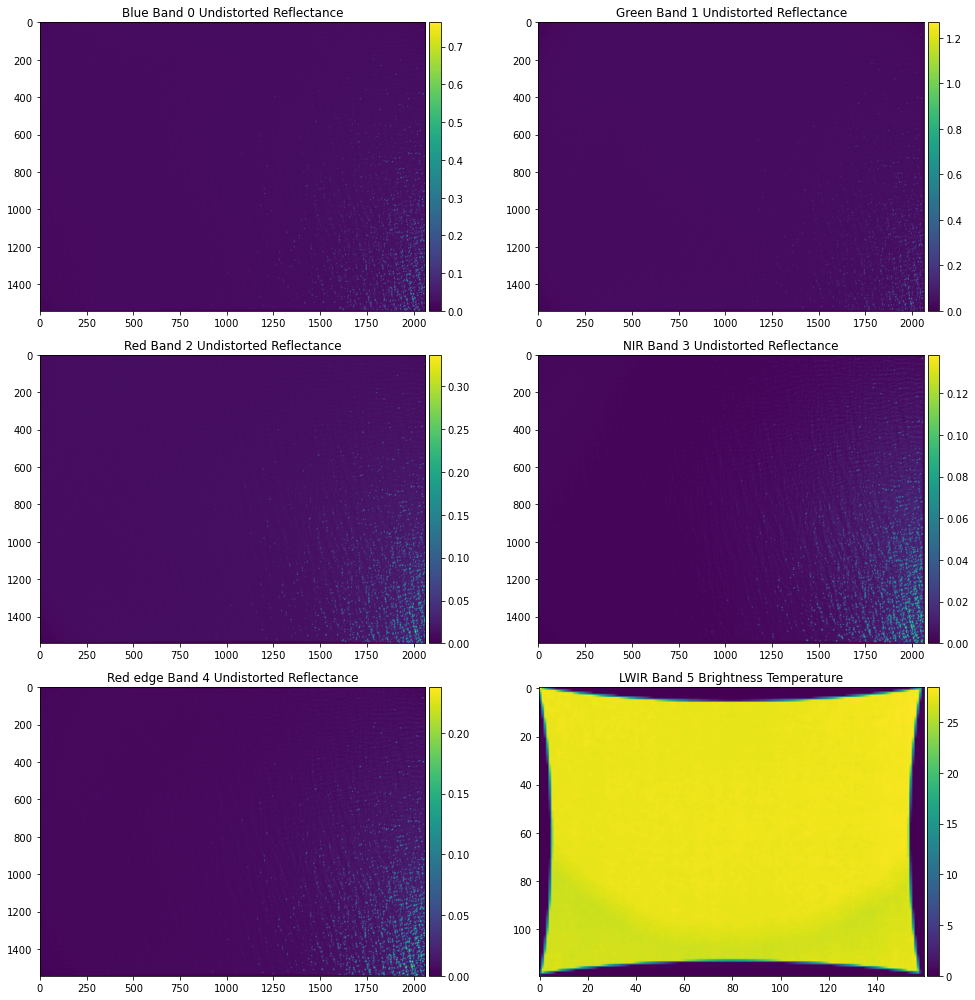

In [31]:
import os, glob
import micasense.capture as capture
%matplotlib inline

panelNames = None

# # This is an older RedEdge image without RigRelatives
# imagePath = os.path.join(os.path.abspath('.'),'data','0000SET','000')
# imageNames = glob.glob(os.path.join(imagePath,'IMG_0001_*.tif'))
# panelNames = glob.glob(os.path.join(imagePath,'IMG_0000_*.tif'))

# # Image from the example RedEdge imageSet (see the ImageSet notebook) without RigRelatives.
# imagePath = os.path.expanduser(os.path.join('~','Downloads','RedEdgeImageSet','0000SET'))
# imageNames = glob.glob(os.path.join(imagePath,'000','IMG_0013_*.tif'))
# panelNames = glob.glob(os.path.join(imagePath,'000','IMG_0000_*.tif'))

# This is an altum image with RigRelatives and a thermal band
imagePath = r"D:\Campo2021-10-TM\0000SET\000"
panelPath = r"D:\Campo2021-10-TM\0000SET\painel-inicio1"
imageNames = glob.glob(os.path.join(imagePath,'IMG_0004_*.tif'))
panelNames = glob.glob(os.path.join(panelPath,'IMG_0000_*.tif'))


# Allow this code to align both radiance and reflectance images; bu excluding
# a definition for panelNames above, radiance images will be used
# For panel images, efforts will be made to automatically extract the panel information
# but if the panel/firmware is before Altum 1.3.5, RedEdge 5.1.7 the panel reflectance
# will need to be set in the panel_reflectance_by_band variable.
# Note: radiance images will not be used to properly create NDVI/NDRE images below.
if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
else:
    panelCap = None

capture = capture.Capture.from_filelist(imageNames)

if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.54, 0.541, 0.539, 0.535, 0.538] #RedEdge band_index order
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
    capture.plot_undistorted_reflectance(panel_irradiance)
else:
    if capture.dls_present():
        img_type='reflectance'
        capture.plot_undistorted_reflectance(capture.dls_irradiance())
    else:
        img_type = "radiance"
        capture.plot_undistorted_radiance()    

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

## Alignment settings
match_index = 1 # Index of the band 
max_alignment_iterations = 10
warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment

print("Alinging images. Depending on settings this can take from a few seconds to many minutes")
# Can potentially increase max_iterations for better results, but longer runtimes
warp_matrices, alignment_pairs = imageutils.align_capture(capture,
                                                          ref_index = match_index,
                                                          max_iterations = max_alignment_iterations,
                                                          warp_mode = warp_mode,
                                                          pyramid_levels = pyramid_levels)

print("Finished Aligning, warp matrices={}".format(warp_matrices))

Alinging images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 4
Finished aligning band 3
Finished aligning band 2
Finished aligning band 0
Finished Aligning, warp matrices=[array([[ 9.9929482e-01,  8.0777053e-04, -1.7579237e+00],
       [-1.4743463e-03,  9.9940085e-01, -2.0381655e+01],
       [ 2.1753803e-07, -2.4589329e-07,  1.0000000e+00]], dtype=float32), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32), array([[ 1.0012937e+00,  1.0102353e-04,  1.6310139e+01],
       [ 1.2466508e-03,  9.9917758e-01, -1.6483683e+01],
       [ 2.0104171e-06,  1.1493307e-07,  1.0000000e+00]], dtype=float32), array([[ 9.9921435e-01,  5.9987360e-05,  8.8070211e+00],
       [ 2.0266161e-03,  1.0004081e+00, -4.6810726e+01],
       [ 2.8406419e-07,  1.6837981e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0001441e+00, -2.0855058e-03,  1.5027837e+00],
       [ 3.6959162e-03,  1.0014679e+00, -1.5599537e+

In [33]:
cropped_dimensions, edges = imageutils.find_crop_bounds(capture, warp_matrices, warp_mode=warp_mode)
im_aligned = imageutils.aligned_capture(capture, warp_matrices, warp_mode, cropped_dimensions, match_index, img_type=img_type)

In [34]:
im_aligned.shape

(1475, 2035, 6)

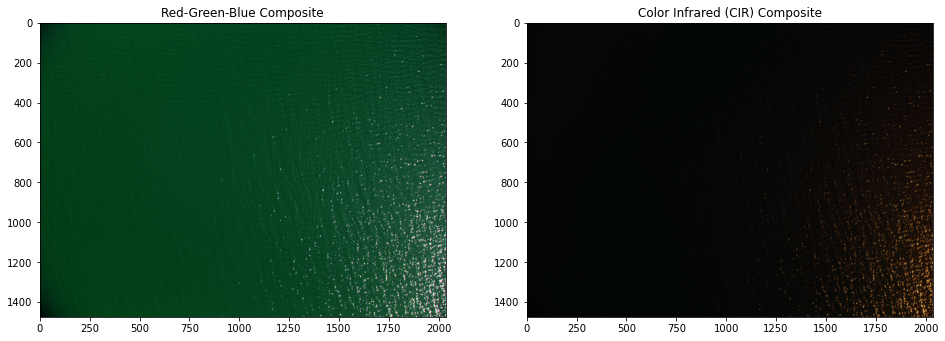

In [35]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [capture.band_names_lower().index('red'),
                    capture.band_names_lower().index('green'),
                    capture.band_names_lower().index('blue')]
cir_band_indices = [capture.band_names_lower().index('nir'),
                    capture.band_names_lower().index('red'),
                    capture.band_names_lower().index('green')]

# Create a normalized stack for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],im_aligned.shape[2]), dtype=np.float32 )

im_min = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 0.5)  # modify these percentiles to adjust contrast
im_max = np.percentile(im_aligned[:,:,rgb_band_indices].flatten(), 99.5)  # for many images, 0.5 and 99.5 are good values

# for rgb true color, we use the same min and max scaling across the 3 bands to 
# maintain the "white balance" of the calibrated image
for i in rgb_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)

rgb = im_display[:,:,rgb_band_indices]

# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
fig, axes = plt.subplots(1, 2, figsize=figsize)
axes[0].set_title("Red-Green-Blue Composite")
axes[0].imshow(rgb)
axes[1].set_title("Color Infrared (CIR) Composite")
axes[1].imshow(cir)
plt.show()

In [4]:
import xarray as xr

ModuleNotFoundError: No module named 'xarray'

In [5]:
data = xr.DataArray(im_aligned, dims=("x", "y", "bands"), coords={"bands": ['Blue', 'Green', 'Red', 'Near-IR', 'RedEdge', 'Thermal']})

NameError: name 'xr' is not defined

In [6]:
data

NameError: name 'data' is not defined

## RELAÇÃO ENTRE BANDAS

In [381]:
def bands_relation(data):
    '''
    Function that calculates band index, band ratios and other index that could be used in wqp"
    
    Parameters:
    img: data array with bands stacked
    
    Return:
    img: image with bands calculated stacked
    '''
    
    blue = data.sel(bands="Blue")
    green = data.sel(bands="Green")
    red = data.sel(bands="Red")
    nir = data.sel(bands="Near-IR")
    red_edge = data.sel(bands="RedEdge")
    

    kivu = (blue - red) / green
    kivu['bands'] = 'KIVU'

    kab_1 = 1.67 - 3.94 * np.log(blue) + 3.78 * np.log(green)
    kab_1=kab_1.fillna(kab_1.mean())
    kab_1 ['bands'] = 'Kab 1(Rs)'
    
    sabi = (red_edge - red) / (blue + green)
    sabi['bands'] = 'SABI'
    
    ndci = (nir - red) / (nir + red)
    ndci['bands'] = 'NDCI'
    
    ndvi = (red_edge - red) / (red_edge + red)
    ndvi['bands'] = 'NDVI'

    two_bda_1 = red_edge / red
    two_bda_1['bands'] = '2BDA_1'

    two_bda_2 = nir / red
    two_bda_2['bands'] = '2BDA_2'
    
    three_bda_1 = (1/blue - 1/nir) * red_edge
    three_bda_1['bands'] = '3BDA_1'
    
    three_bda_mod = (1/blue - 1/nir)
    three_bda_mod['bands'] = '3BDA_MOD'
    
    b3_b1 = (green - blue) / (green + blue)
    b3_b1['bands'] = 'B3B1'
    
    gb1 = green / blue
    gb1['bands'] = 'GB1'
    
    gr = green / red
    gr['bands'] = 'GR'
    
    list_arrays = [kivu, kab_1, sabi, ndci, ndvi, two_bda_1, two_bda_2, three_bda_1, three_bda_mod, b3_b1, gb1, gr]
    
    for arr in list_arrays:
        data = xr.concat(objs=[data, arr], dim = 'bands')
        
    return data

In [382]:
img_array = bands_relation(data)

In [383]:
img_array

<xarray.DataArray (x: 1475, y: 2035, bands: 18)>
array([[[ 1.75870974e-02,  2.07745768e-02,  9.26832296e-03, ...,
          8.30902010e-02,  1.18123960e+00,  2.24146008e+00],
        [ 1.77850351e-02,  2.22551450e-02,  9.98172723e-03, ...,
          1.11640602e-01,  1.25134110e+00,  2.22958851e+00],
        [ 1.68853737e-02,  1.96794644e-02,  9.57053248e-03, ...,
          7.64146894e-02,  1.16547406e+00,  2.05625606e+00],
        ...,
        [ 1.84732378e-02,  2.70822123e-02,  9.63823404e-03, ...,
          1.88977927e-01,  1.46602416e+00,  2.80987287e+00],
        [ 1.79664697e-02,  2.32166797e-02,  9.92070604e-03, ...,
          1.27484411e-01,  1.29222274e+00,  2.34022450e+00],
        [ 1.51167493e-02,  2.43569985e-02,  9.76515375e-03, ...,
          2.34085917e-01,  1.61125898e+00,  2.49427700e+00]],

       [[ 1.82726029e-02,  2.16442887e-02,  8.16084631e-03, ...,
          8.44676420e-02,  1.18452132e+00,  2.65221119e+00],
        [ 1.85010098e-02,  2.40482204e-02,  9.70620289e-03, ...,
          1.30371585e-01,  1.29983282e+00,  2.47761369e+00],
        [ 1.73008386e-02,  1.74545012e-02,  8.74157157e-03, ...,
          4.42126673e-03,  1.00888181e+00,  1.99672353e+00],
...
          3.56435597e-01,  2.10769200e+00,  1.79448926e+00],
        [ 2.97595486e-02,  7.49117285e-02,  5.21055050e-02, ...,
          4.31371242e-01,  2.51723337e+00,  1.43769312e+00],
        [ 2.89477296e-02,  4.48182747e-02,  1.64988190e-01, ...,
          2.15147138e-01,  1.54824841e+00,  2.71645337e-01]],

       [[ 1.27919298e-02,  1.29321050e-02,  4.93643526e-03, ...,
          5.44919260e-03,  1.01095808e+00,  2.61972547e+00],
        [ 1.34146446e-02,  9.57337767e-03,  4.59188735e-03, ...,
         -1.67098626e-01,  7.13651240e-01,  2.08484602e+00],
        [ 1.38288718e-02,  1.54234935e-02,  5.41676162e-03, ...,
          5.45125715e-02,  1.11531103e+00,  2.84736419e+00],
        ...,
        [ 2.82520372e-02,  3.64024565e-02,  3.06737572e-02, ...,
          1.26061141e-01,  1.28848958e+00,  1.18676221e+00],
        [ 2.95578539e-02,  3.53656448e-02,  3.07843536e-02, ...,
          8.94559175e-02,  1.19648898e+00,  1.14881885e+00],
        [ 3.11303306e-02,  3.82880904e-02,  6.36242628e-02, ...,
          1.03110380e-01,  1.22992885e+00,  6.01784408e-01]]],
      dtype=float32)
Coordinates:
  * bands    (bands) <U9 'Blue' 'Green' 'Red' 'Near-IR' ... 'B3B1' 'GB1' 'GR'
Dimensions without coordinates: x, y

## Aplicando no modelo

### Secchi

In [391]:
wqp = 'Secchi (cm)'
filename = model_dict.get('secchi_model')
print(filename)
loaded_model = pickle.load(open(filename, 'rb'))

../modelagem/teia_modelagem/best_models/TM_30m/secchi_cm_XGBRegressor_exp.pkl


In [392]:
loaded_model.feature_names_in_

array(['Blue', 'Green', 'Red', 'KIVU', 'Kab 1(Rs)', 'NDCI', '2BDA_2',
       '3BDA_1', 'B3B1', 'GB1', 'GR'], dtype='<U9')

In [390]:
def func(xarray, model, transform, wqp):
    
    input_attributes = model.feature_names_in_.tolist() #importa os atributos de entrada
    
    #print(f"data: {data.shape} | x: {bands.shape} ")
    
    
    
    stacked = xarray.stack(z=("x", "y")) #transforma matriz para vetor para realizar operacao
    #return stacked
    stacked2 = stacked.sel(bands = loaded_model.feature_names_in_.tolist()) #seleciona as bandas
    #print(stacked2.T.shape)
    #print(stacked2.T.values)
    #print(stacked2.T.max())
    #df_temp = stacked2.T.to_dataframe(name = "SIMOA")
    #return df_temp
    y_pred = model.predict(stacked2.T.values) #predicao do modelo
    
    #y_pred_da = xr.DataArray(np.reshape(np.exp(y_pred), (y_pred.shape[0], 1)), dims=("z", "bands"))
    if transform == 'exp':
        y_pred_da = xr.DataArray(np.exp(y_pred), dims=("z"))
    else:
        y_pred_da = xr.DataArray(y_pred, dims=("z"))
        
    y_pred_da["bands"] = wqp
    #y_pred_da.assign_coords({"bands": "Chla"})
    temp = xr.concat(objs=[stacked.T, y_pred_da],dim='bands')
    
    temp = temp.unstack("z")
    return temp

In [393]:
img_secchi = func(img_array, loaded_model, 'exp', wqp)

In [394]:
img_secchi

<xarray.DataArray (bands: 19, x: 1475, y: 2035)>
array([[[1.75870974e-02, 1.77850351e-02, 1.68853737e-02, ...,
         1.84732378e-02, 1.79664697e-02, 1.51167493e-02],
        [1.82726029e-02, 1.85010098e-02, 1.73008386e-02, ...,
         1.76842678e-02, 1.75457783e-02, 1.42051661e-02],
        [1.87101997e-02, 2.02144757e-02, 1.90288778e-02, ...,
         1.70506183e-02, 1.74154602e-02, 1.51384445e-02],
        ...,
        [1.33874146e-02, 1.43748308e-02, 1.44789759e-02, ...,
         4.58023250e-02, 7.14948550e-02, 7.07926974e-02],
        [1.37535650e-02, 1.43311955e-02, 1.42304217e-02, ...,
         2.69596782e-02, 2.97595486e-02, 2.89477296e-02],
        [1.27919298e-02, 1.34146446e-02, 1.38288718e-02, ...,
         2.82520372e-02, 2.95578539e-02, 3.11303306e-02]],

       [[2.07745768e-02, 2.22551450e-02, 1.96794644e-02, ...,
         2.70822123e-02, 2.32166797e-02, 2.43569985e-02],
        [2.16442887e-02, 2.40482204e-02, 1.74545012e-02, ...,
         2.59304345e-02, 2.48556733e-02, 2.64661610e-02],
        [2.07342710e-02, 2.18675472e-02, 1.66657120e-02, ...,
         2.56517250e-02, 2.91929189e-02, 2.24343836e-02],
...
        [3.62052321e+00, 3.00880957e+00, 2.58360195e+00, ...,
         4.85514641e+00, 6.87149858e+00, 3.88856173e-01],
        [3.06739902e+00, 2.74070883e+00, 2.67630935e+00, ...,
         1.79448926e+00, 1.43769312e+00, 2.71645337e-01],
        [2.61972547e+00, 2.08484602e+00, 2.84736419e+00, ...,
         1.18676221e+00, 1.14881885e+00, 6.01784408e-01]],

       [[2.05043304e+02, 2.18219604e+02, 2.03816238e+02, ...,
         2.12073044e+02, 2.21044388e+02, 2.29345215e+02],
        [2.11140289e+02, 2.21597809e+02, 2.07075836e+02, ...,
         2.24612183e+02, 2.22037292e+02, 2.22159515e+02],
        [2.03980148e+02, 2.14666824e+02, 2.13801590e+02, ...,
         2.28442917e+02, 2.09889435e+02, 2.40759384e+02],
        ...,
        [2.91328461e+02, 2.72397949e+02, 2.31961716e+02, ...,
         1.74898865e+02, 1.36199234e+02, 1.37801819e+02],
        [2.72397949e+02, 2.67553284e+02, 2.32181366e+02, ...,
         2.01480804e+02, 1.43032623e+02, 1.98502365e+02],
        [2.59229431e+02, 2.77580627e+02, 2.09173294e+02, ...,
         1.72224594e+02, 1.79637909e+02, 1.44382294e+02]]], dtype=float32)
Coordinates:
  * bands    (bands) <U11 'Blue' 'Green' 'Red' ... 'GB1' 'GR' 'Secchi (cm)'
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1468 1469 1470 1471 1472 1473 1474
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 2028 2029 2030 2031 2032 2033 2034

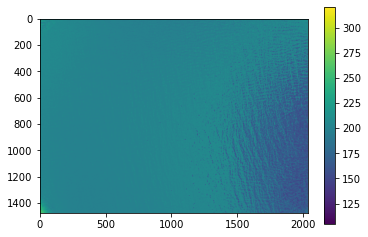

In [422]:
plt.imshow(img_secchi.sel(bands = 'Secchi (cm)'))
plt.colorbar()

### CHLA

In [396]:
wqp = 'Chl (rfu)'
filename = model_dict.get('chl_model')
print(filename)
loaded_model = pickle.load(open(filename, 'rb'))

../modelagem/teia_modelagem/best_models/TM_30m/chl_rfu_XGBRegressor_log.pkl


In [397]:
loaded_model.feature_names_in_

array(['Blue', 'Green', 'Kab 1(Rs)', 'B3B1', 'GB1'], dtype='<U9')

In [398]:
img_chla = func(img_array, loaded_model, 'log', wqp)

In [399]:
img_chla

<xarray.DataArray (bands: 19, x: 1475, y: 2035)>
array([[[1.75870974e-02, 1.77850351e-02, 1.68853737e-02, ...,
         1.84732378e-02, 1.79664697e-02, 1.51167493e-02],
        [1.82726029e-02, 1.85010098e-02, 1.73008386e-02, ...,
         1.76842678e-02, 1.75457783e-02, 1.42051661e-02],
        [1.87101997e-02, 2.02144757e-02, 1.90288778e-02, ...,
         1.70506183e-02, 1.74154602e-02, 1.51384445e-02],
        ...,
        [1.33874146e-02, 1.43748308e-02, 1.44789759e-02, ...,
         4.58023250e-02, 7.14948550e-02, 7.07926974e-02],
        [1.37535650e-02, 1.43311955e-02, 1.42304217e-02, ...,
         2.69596782e-02, 2.97595486e-02, 2.89477296e-02],
        [1.27919298e-02, 1.34146446e-02, 1.38288718e-02, ...,
         2.82520372e-02, 2.95578539e-02, 3.11303306e-02]],

       [[2.07745768e-02, 2.22551450e-02, 1.96794644e-02, ...,
         2.70822123e-02, 2.32166797e-02, 2.43569985e-02],
        [2.16442887e-02, 2.40482204e-02, 1.74545012e-02, ...,
         2.59304345e-02, 2.48556733e-02, 2.64661610e-02],
        [2.07342710e-02, 2.18675472e-02, 1.66657120e-02, ...,
         2.56517250e-02, 2.91929189e-02, 2.24343836e-02],
...
        [3.62052321e+00, 3.00880957e+00, 2.58360195e+00, ...,
         4.85514641e+00, 6.87149858e+00, 3.88856173e-01],
        [3.06739902e+00, 2.74070883e+00, 2.67630935e+00, ...,
         1.79448926e+00, 1.43769312e+00, 2.71645337e-01],
        [2.61972547e+00, 2.08484602e+00, 2.84736419e+00, ...,
         1.18676221e+00, 1.14881885e+00, 6.01784408e-01]],

       [[5.89207947e-01, 5.89207947e-01, 5.89207947e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01],
        [5.89207947e-01, 5.89207947e-01, 5.89207947e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01],
        [5.89207947e-01, 5.89207947e-01, 5.28375268e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01],
        ...,
        [5.89207947e-01, 5.89207947e-01, 5.89207947e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01],
        [5.89207947e-01, 5.89207947e-01, 5.89207947e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01],
        [5.89207947e-01, 6.52900338e-01, 5.89207947e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01]]], dtype=float32)
Coordinates:
  * bands    (bands) <U9 'Blue' 'Green' 'Red' ... 'GB1' 'GR' 'Chl (rfu)'
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1468 1469 1470 1471 1472 1473 1474
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 2028 2029 2030 2031 2032 2033 2034

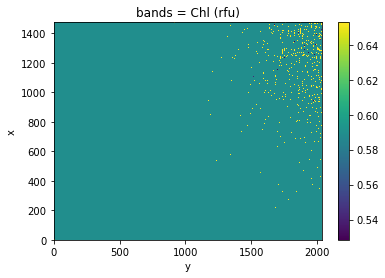

In [400]:
img_chla.sel(bands = wqp).plot()

### PC

In [401]:
wqp = 'PC (rfu)'
filename = model_dict.get('pc_model')
print(filename)
loaded_model = pickle.load(open(filename, 'rb'))

../modelagem/teia_modelagem/best_models/TM_30m/pc_rfu_RandomForestRegressor_linear.pkl


In [402]:
loaded_model.feature_names_in_

array(['Blue', 'Green', 'Red', 'KIVU', 'Kab 1(Rs)', 'NDCI', '2BDA_2',
       '3BDA_1', 'B3B1', 'GB1', 'GR'], dtype=object)

In [ ]:
#Secchi array(['Blue', 'Green', 'Red', 'KIVU', 'Kab 1(Rs)', 'NDCI', '2BDA_2','3BDA_1', 'B3B1', 'GB1', 'GR'], dtype='<U9')
#Chla array(['Blue', 'Green', 'Kab 1(Rs)', 'B3B1', 'GB1'], dtype='<U9')
#PC array(['Blue', 'Green', 'Red', 'KIVU', 'Kab 1(Rs)', 'NDCI', '2BDA_2','3BDA_1', 'B3B1', 'GB1', 'GR'], dtype=object)

In [403]:
img_pc = func(img_array, loaded_model, 'linear', wqp)

In [404]:
img_pc

<xarray.DataArray (bands: 19, x: 1475, y: 2035)>
array([[[ 1.75870974e-02,  1.77850351e-02,  1.68853737e-02, ...,
          1.84732378e-02,  1.79664697e-02,  1.51167493e-02],
        [ 1.82726029e-02,  1.85010098e-02,  1.73008386e-02, ...,
          1.76842678e-02,  1.75457783e-02,  1.42051661e-02],
        [ 1.87101997e-02,  2.02144757e-02,  1.90288778e-02, ...,
          1.70506183e-02,  1.74154602e-02,  1.51384445e-02],
        ...,
        [ 1.33874146e-02,  1.43748308e-02,  1.44789759e-02, ...,
          4.58023250e-02,  7.14948550e-02,  7.07926974e-02],
        [ 1.37535650e-02,  1.43311955e-02,  1.42304217e-02, ...,
          2.69596782e-02,  2.97595486e-02,  2.89477296e-02],
        [ 1.27919298e-02,  1.34146446e-02,  1.38288718e-02, ...,
          2.82520372e-02,  2.95578539e-02,  3.11303306e-02]],

       [[ 2.07745768e-02,  2.22551450e-02,  1.96794644e-02, ...,
          2.70822123e-02,  2.32166797e-02,  2.43569985e-02],
        [ 2.16442887e-02,  2.40482204e-02,  1.74545012e-02, ...,
          2.59304345e-02,  2.48556733e-02,  2.64661610e-02],
        [ 2.07342710e-02,  2.18675472e-02,  1.66657120e-02, ...,
          2.56517250e-02,  2.91929189e-02,  2.24343836e-02],
...
        [ 3.62052321e+00,  3.00880957e+00,  2.58360195e+00, ...,
          4.85514641e+00,  6.87149858e+00,  3.88856173e-01],
        [ 3.06739902e+00,  2.74070883e+00,  2.67630935e+00, ...,
          1.79448926e+00,  1.43769312e+00,  2.71645337e-01],
        [ 2.61972547e+00,  2.08484602e+00,  2.84736419e+00, ...,
          1.18676221e+00,  1.14881885e+00,  6.01784408e-01]],

       [[-1.56100000e-01, -1.94610000e-01, -1.63960000e-01, ...,
         -1.62550000e-01, -1.93660000e-01, -2.05855000e-01],
        [-2.42030000e-01, -2.19600000e-01, -1.55400000e-01, ...,
         -3.00667500e-01, -3.09940000e-01, -1.88147500e-01],
        [-1.52500000e-01, -1.55070000e-01, -1.52740000e-01, ...,
          7.85400000e-02, -9.49000000e-03,  2.69616667e-02],
        ...,
        [ 2.72870000e-01, -1.40330000e-01, -1.55650000e-01, ...,
         -3.90843182e-02, -2.59724134e-02, -9.46800000e-02],
        [-8.28600000e-02, -2.75830000e-01, -2.47130000e-01, ...,
         -1.66410000e-01, -9.62666667e-02,  2.20550609e-01],
        [-2.06360000e-01, -7.50200000e-02, -2.36530000e-01, ...,
         -1.18950000e-01, -9.53700000e-02, -1.18970000e-01]]])
Coordinates:
  * bands    (bands) <U9 'Blue' 'Green' 'Red' ... 'GB1' 'GR' 'PC (rfu)'
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1468 1469 1470 1471 1472 1473 1474
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 2028 2029 2030 2031 2032 2033 2034

In [408]:
img_pc.sel(bands = wqp).min()

<xarray.DataArray ()>
array(-0.45073)
Coordinates:
    bands    <U9 'PC (rfu)'

In [409]:
img_pc.sel(bands = wqp).max()

<xarray.DataArray ()>
array(2.979)
Coordinates:
    bands    <U9 'PC (rfu)'

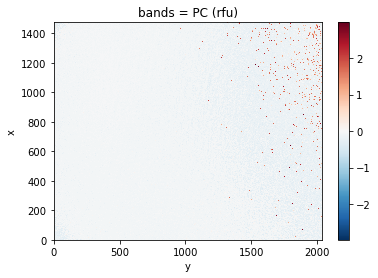

In [405]:
img_pc.sel(bands = wqp).plot()

### FDOM

In [410]:
wqp = 'FDOM (rfu)'
filename = model_dict.get('fdom_model')
print(filename)
loaded_model = pickle.load(open(filename, 'rb'))

../modelagem/teia_modelagem/best_models/TM_30m/fdom_rfu_RandomForestRegressor_min_max.pkl


In [411]:
loaded_model.feature_names_in_

AttributeError: 'RandomForestRegressor' object has no attribute 'feature_names_in_'

In [269]:
img_modeled = func(img_modeled, loaded_model, 'min_max', wqp)

AttributeError: 'RandomForestRegressor' object has no attribute 'feature_names_in_'

In [261]:
img_modeled

<xarray.DataArray (bands: 20, x: 1475, y: 2035)>
array([[[1.75870974e-02, 1.77850351e-02, 1.68853737e-02, ...,
         1.84732378e-02, 1.79664697e-02, 1.51167493e-02],
        [1.82726029e-02, 1.85010098e-02, 1.73008386e-02, ...,
         1.76842678e-02, 1.75457783e-02, 1.42051661e-02],
        [1.87101997e-02, 2.02144757e-02, 1.90288778e-02, ...,
         1.70506183e-02, 1.74154602e-02, 1.51384445e-02],
        ...,
        [1.33874146e-02, 1.43748308e-02, 1.44789759e-02, ...,
         4.58023250e-02, 7.14948550e-02, 7.07926974e-02],
        [1.37535650e-02, 1.43311955e-02, 1.42304217e-02, ...,
         2.69596782e-02, 2.97595486e-02, 2.89477296e-02],
        [1.27919298e-02, 1.34146446e-02, 1.38288718e-02, ...,
         2.82520372e-02, 2.95578539e-02, 3.11303306e-02]],

       [[2.07745768e-02, 2.22551450e-02, 1.96794644e-02, ...,
         2.70822123e-02, 2.32166797e-02, 2.43569985e-02],
        [2.16442887e-02, 2.40482204e-02, 1.74545012e-02, ...,
         2.59304345e-02, 2.48556733e-02, 2.64661610e-02],
        [2.07342710e-02, 2.18675472e-02, 1.66657120e-02, ...,
         2.56517250e-02, 2.91929189e-02, 2.24343836e-02],
...
        [2.91328461e+02, 2.72397949e+02, 2.31961716e+02, ...,
         1.74898865e+02, 1.36199234e+02, 1.37801819e+02],
        [2.72397949e+02, 2.67553284e+02, 2.32181366e+02, ...,
         2.01480804e+02, 1.43032623e+02, 1.98502365e+02],
        [2.59229431e+02, 2.77580627e+02, 2.09173294e+02, ...,
         1.72224594e+02, 1.79637909e+02, 1.44382294e+02]],

       [[5.89207947e-01, 5.89207947e-01, 5.89207947e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01],
        [5.89207947e-01, 5.89207947e-01, 5.89207947e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01],
        [5.89207947e-01, 5.89207947e-01, 5.28375268e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01],
        ...,
        [5.89207947e-01, 5.89207947e-01, 5.89207947e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01],
        [5.89207947e-01, 5.89207947e-01, 5.89207947e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01],
        [5.89207947e-01, 6.52900338e-01, 5.89207947e-01, ...,
         5.89207947e-01, 5.89207947e-01, 5.89207947e-01]]], dtype=float32)
Coordinates:
  * bands    (bands) <U11 'Blue' 'Green' 'Red' ... 'Secchi (cm)' 'Chla (rfu)'
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1468 1469 1470 1471 1472 1473 1474
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 2028 2029 2030 2031 2032 2033 2034

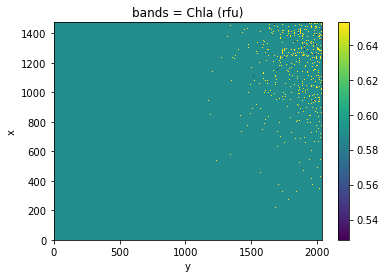

In [262]:
img_modeled.sel(bands = wqp).plot()

### Turbidez

In [418]:
wqp = 'Turbidez (fnu)'
#filename = model_dict.get('turb_model')
#filename = "../modelagem/teia_modelagem/best_models/TM_30m/turb_fnu_RandomForestRegressor_exp_v2.pkl"
filename = "../modelagem/teia_modelagem/best_models/TM_30m/turb_fnu_XGBRegressor_min_max_v3.pkl"
print(filename)
loaded_model = pickle.load(open(filename, 'rb'))

../modelagem/teia_modelagem/best_models/TM_30m/turb_fnu_XGBRegressor_min_max_v3.pkl


In [419]:
loaded_model.feature_names_in_

AttributeError: `feature_names_in_` is defined only when `X` has feature names that are all strings.

In [414]:
img_modeled = func(img_array, loaded_model, 'exp', wqp)

In [415]:
img_modeled

<xarray.DataArray (bands: 19, x: 1475, y: 2035)>
array([[[1.75870974e-02, 1.77850351e-02, 1.68853737e-02, ...,
         1.84732378e-02, 1.79664697e-02, 1.51167493e-02],
        [1.82726029e-02, 1.85010098e-02, 1.73008386e-02, ...,
         1.76842678e-02, 1.75457783e-02, 1.42051661e-02],
        [1.87101997e-02, 2.02144757e-02, 1.90288778e-02, ...,
         1.70506183e-02, 1.74154602e-02, 1.51384445e-02],
        ...,
        [1.33874146e-02, 1.43748308e-02, 1.44789759e-02, ...,
         4.58023250e-02, 7.14948550e-02, 7.07926974e-02],
        [1.37535650e-02, 1.43311955e-02, 1.42304217e-02, ...,
         2.69596782e-02, 2.97595486e-02, 2.89477296e-02],
        [1.27919298e-02, 1.34146446e-02, 1.38288718e-02, ...,
         2.82520372e-02, 2.95578539e-02, 3.11303306e-02]],

       [[2.07745768e-02, 2.22551450e-02, 1.96794644e-02, ...,
         2.70822123e-02, 2.32166797e-02, 2.43569985e-02],
        [2.16442887e-02, 2.40482204e-02, 1.74545012e-02, ...,
         2.59304345e-02, 2.48556733e-02, 2.64661610e-02],
        [2.07342710e-02, 2.18675472e-02, 1.66657120e-02, ...,
         2.56517250e-02, 2.91929189e-02, 2.24343836e-02],
...
        [3.62052321e+00, 3.00880957e+00, 2.58360195e+00, ...,
         4.85514641e+00, 6.87149858e+00, 3.88856173e-01],
        [3.06739902e+00, 2.74070883e+00, 2.67630935e+00, ...,
         1.79448926e+00, 1.43769312e+00, 2.71645337e-01],
        [2.61972547e+00, 2.08484602e+00, 2.84736419e+00, ...,
         1.18676221e+00, 1.14881885e+00, 6.01784408e-01]],

       [[1.18983243e+00, 1.34236009e+00, 1.16868417e+00, ...,
         1.45048790e+00, 1.34490794e+00, 1.33701360e+00],
        [1.34483960e+00, 1.37146815e+00, 1.20537048e+00, ...,
         1.46088472e+00, 1.44580863e+00, 1.92266856e+00],
        [1.21833249e+00, 1.32414641e+00, 1.20170407e+00, ...,
         1.43999583e+00, 1.46172557e+00, 1.37404273e+00],
        ...,
        [1.19588142e+00, 1.19565134e+00, 1.19143583e+00, ...,
         1.91492933e+00, 3.14430716e+00, 1.54479330e+00],
        [1.19799065e+00, 1.19381957e+00, 1.19623038e+00, ...,
         1.80775096e+00, 2.43674086e+00, 1.22580201e+00],
        [1.19260990e+00, 1.17907184e+00, 1.18711779e+00, ...,
         1.44632618e+00, 1.48221024e+00, 1.50542024e+00]]])
Coordinates:
  * bands    (bands) <U14 'Blue' 'Green' 'Red' ... 'GB1' 'GR' 'Turbidez (fnu)'
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1468 1469 1470 1471 1472 1473 1474
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 2028 2029 2030 2031 2032 2033 2034

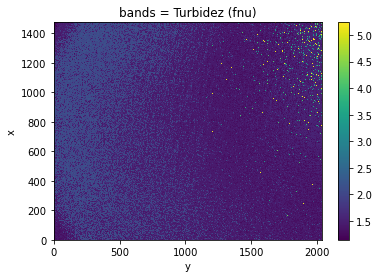

In [416]:
img_modeled.sel(bands = wqp).plot()